# Extract Patches: 
## Divide each orthomosaic into patches of size 256*256. The patches are stored into three folders `rumex`, `other` and `outside` where `outside` consists of those pathces that are outside ROI and will eventually be discarded.  

## After extracting all the patches store them in `imagenet` format as show below.
```
train
|   |__rumex
|   |__other
|   
valid
|   |__rumex
|   |__other
|
test
    |__rumex
    |__other
```  

WENR_ortho_Rumex_10m_1_nw


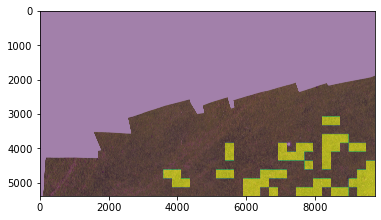

WENR_ortho_Rumex_10m_2_sw


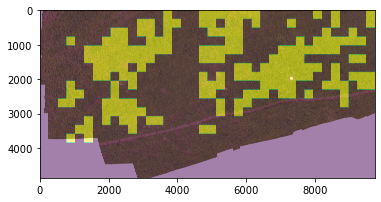

WENR_ortho_Rumex_10m_3_ne


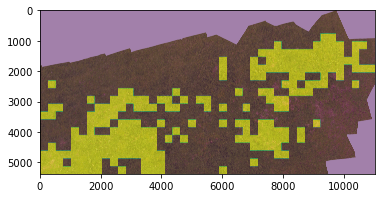

WENR_ortho_Rumex_10m_4_se


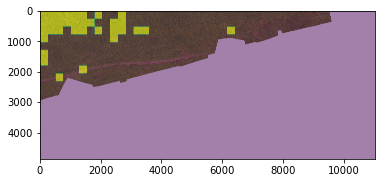

In [1]:
import os
import xmltodict
import numpy as np
from skimage import io as skio
import matplotlib.pyplot as plt
import xml.etree.ElementTree as et
from skimage.util import img_as_float
from skimage.draw import rectangle_perimeter
from skimage.util.shape import view_as_blocks
from warnings import filterwarnings
filterwarnings('ignore')

# %%
save = 1
patch_size = 256
flying_height = "10m"
src_folder = 'data/ortho/'
dst_folder = 'data/temp_ortho_to_patches/'

base_filenames = {"10m": ['WENR_ortho_Rumex_10m_1_nw',
                          'WENR_ortho_Rumex_10m_2_sw',
                          'WENR_ortho_Rumex_10m_3_ne',
                          'WENR_ortho_Rumex_10m_4_se'],
                  "15m": ['WENR_ortho_Rumex_15m_2_sw',
                          'WENR_ortho_Rumex_15m_4_se']}

for base_filename in base_filenames[flying_height]:
    # parse xml file of 'base_filename' and get image meatadata info
    quadrant = base_filename.split("_")[-1]
    print(base_filename)
    imfile = base_filename + '.png'
    xmlfile = base_filename + '.xml'
    root = et.parse(src_folder + xmlfile).getroot()
    xmlstr = et.tostring(root, encoding='utf-8', method='xml')
    xmldict = dict(xmltodict.parse(xmlstr))

    # actual image size
    im_size = xmldict['annotation']['size']
    im_height = int(im_size['height'])
    im_width = int(im_size['width'])
    im_depth = int(im_size['depth'])

    # crop image to be a multiple of patch_size
    npatches_w = im_width // patch_size
    npatches_h = im_height // patch_size
    im = skio.imread(src_folder + imfile)

    # split image into patches
    ### create labels for each patch: rumex, other or outside ###
    # step 1: get rumex bbox from xml file
    # step 2: if bbox overlaps with image patch label it as rumex
    # Note: use mask to determine if the patches are within or outside field
    
    # logic of finding the overlap between patch and ground truth bbox
    # 1. find the patches that the true rumex bbox straddles: eg: bbox[0] // patch_size
    # 2. label those patches as rumex
    
    im = im[:npatches_h * patch_size, :npatches_w * patch_size, :]
    im_patches = np.squeeze(view_as_blocks(im, (patch_size, patch_size, 4)))
    
    im_label = np.zeros(im.shape[:2])
    label_patches = view_as_blocks(im_label, (patch_size, patch_size))

    
    objects = xmldict['annotation']['object']
    nobjects = len(objects)    
    for i in range(nobjects):
        obj_i = objects[i]
        
        if obj_i['name'] == 'rumex':
            temp = obj_i['bndbox']
            bbox = [temp['xmin'], temp['ymin'], temp['xmax'], temp['ymax']]
            bbox = [int(x) for x in bbox]

            xmin_r = bbox[0] // patch_size
            ymin_r = bbox[1] // patch_size
            xmax_r = bbox[2] // patch_size
            ymax_r = bbox[3] // patch_size

            if (xmax_r < npatches_w) & (ymax_r < npatches_h):
                if xmax_r - xmin_r >= 1:
                    x_patches_with_rumex = list(np.arange(xmin_r, xmax_r + 1))
                else:
                    x_patches_with_rumex = [xmin_r]

                if ymax_r - ymin_r >= 1:
                    y_patches_with_rumex = list(np.arange(ymin_r, ymax_r + 1))
                else:
                    y_patches_with_rumex = [ymin_r]

                for col in x_patches_with_rumex:
                    for row in y_patches_with_rumex:
                        label_patches[row, col] = 1

    # save the patches into seperate folders as per their labels
    # 1. set patch id to their position in image (from top left to bottom right) 
    # 2. set patch file name to id.
    
    for row in np.arange(npatches_h):
        for col in np.arange(npatches_w):
            # create patch id and name for storing
            patch_id = npatches_w * row + col
  
            if patch_id < 10:
                patch_id_str = "0000"+str(patch_id)
            elif patch_id >= 10 and patch_id < 100:
                patch_id_str = "000"+str(patch_id)
            elif patch_id >= 100 and patch_id < 1000:
                patch_id_str = "00"+str(patch_id)
            elif patch_id >= 1000 and patch_id < 10000:
                patch_id_str = "0"+str(patch_id)
                
            patch_name = patch_id_str + "_" + quadrant + '_patch.png'
            patch = im_patches[row, col]
            label = label_patches[row, col]
            patch_mask = patch[:, :, -1]
            # if patch is outside the field save in "outside" folder
            # if patch label is rumex then save in "rumex" folder
            # if patch label is not rumex then save in "other" folder 
            if np.sum(patch_mask == 255) == np.prod(patch_mask.shape):
                if np.sum(label) == patch_size * patch_size:
                    dst = dst_folder + base_filename + '/rumex/'
                else:
                    dst = dst_folder + base_filename + '/other/'
            else:  # outside field
                dst = dst_folder + base_filename + '/outside/'

            if not os.path.exists(dst):
                os.makedirs(dst)
            if save:
                skio.imsave(dst + patch_name, patch[:, :, :3])
                # print(dst + patch_name)
    fig, ax = plt.subplots(1)
    ax.imshow(im)
    ax.imshow(im_label, alpha=0.5)
    # fig.savefig('test.png')
    plt.show()

# Data augmentation
## Augment the training data by creating a blurred version of each image patch. This will help the model cope with image taken from different heights to some extent. 

In [2]:
import os
import glob
import numpy as np
from PIL import Image
import torchvision.transforms as T
np.random.seed(0)

save=1
suffix = "_a"
# transformations for augmentation
blur = T.GaussianBlur(3, 3/3)
for class_name in ["rumex", "other"]:    
    print(class_name)    
    src = f"data/10m/train/{class_name}/"
    dst = f"data/10m/train_temp{suffix}/{class_name}/"
    print(f"files will be stored in {dst}")
    if not os.path.exists(dst):
        os.makedirs(dst)
    files = glob.glob(src+'/*.png')
    for i, f in enumerate(files):        
        patch_name = f.split('/')[-1].split('.')[0]        
        im = Image.open(f)
        im_blurred = blur(im)        
        if save:
            im_blurred.save(f"{dst}{patch_name}{suffix}.png")    

rumex
files will be stored in data/10m/train_temp_a/rumex/
other
files will be stored in data/10m/train_temp_a/other/
